In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import shap

In [2]:
dig = pd.read_excel('FINAL RAW/digital_ads.xlsx')
lex = pd.read_excel('FINAL RAW/lexia.xlsx')
nls = pd.read_excel('FINAL RAW/nielsen_national.xlsx')
osa = pd.read_excel('FINAL RAW/osa_sb.xlsx')
gads = pd.read_excel('FINAL RAW/g_ads.xlsx')
awop = pd.read_excel('FINAL RAW/awop.xlsx')
med = pd.read_excel('FINAL RAW/medical.xlsx')
switch = pd.read_excel('switcher.xlsx')

In [3]:
dig = dig.set_index('Month')
lex = lex.set_index('Date')
nls = nls.set_index('ds')
osa = osa.set_index('Date')
gads = gads.set_index('Month')
awop = awop.set_index('ds')
med = med.set_index('Period')
switch = switch.set_index('Month')

In [4]:
lex = lex.fillna(0)
dig = dig.fillna(0)

In [5]:
df = pd.merge(nls,lex, how='outer', left_index=True, right_index=True)
df = pd.merge(df, osa, how='left', left_index=True, right_index=True)
df = pd.merge(df,dig, how='left', left_index=True, right_index=True)
df = pd.merge(df,gads, how='left', left_index=True, right_index=True)
df = pd.merge(df,awop, how='left', left_index=True, right_index=True)
df = pd.merge(df,med, how='left', left_index=True, right_index=True)
df = pd.merge(df,switch, how='left', left_index=True, right_index=True)

In [6]:
df = df.loc['2019-07-01':'2021-07-01']

In [7]:
def mape(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
df['pi_bebelac'] = df['Avg Price per Gr_Susu Bendera']/df['Avg Price per Gr_Bebelac']
df['pi_dancow'] = df['Avg Price per Gr_Susu Bendera']/df['Avg Price per Gr_Dancow']
df['pi_ff'] = df['Avg Price per Gr_Susu Bendera']/df['Avg Price per Gr_Frisian Flag']
df['pi_lacto'] = df['Avg Price per Gr_Susu Bendera']/df['Avg Price per Gr_Lactogrow']
df['pi_nestle'] = df['Avg Price per Gr_Susu Bendera']/df['Avg Price per Gr_Nestle']
df['pi_sgm'] = df['Avg Price per Gr_Susu Bendera']/df['Avg Price per Gr_SGM']
df['pi_vidoran'] = df['Avg Price per Gr_Susu Bendera']/df['Avg Price per Gr_Vidoran']
df['new_user'] = df['SPG'] + df['HIMPAUDI']

In [9]:
for c in df[['Avg Price per Gr_Susu Bendera', 'ND Max_Bebelac', 'ND Max_Dancow','ND Max_Frisian Flag',
             'ND Max_Lactogrow','ND Max_Nestle','ND Max_SGM','ND Max_Susu Bendera','ND Max_Vidoran',
             'SPPD (Vol/ND)_Susu Bendera','WD Max_Susu Bendera','avg price per pack_Susu Bendera', 'DISPLAY',
             'SOS IFT', 'SOS SUSU BENDERA','osa_sb_driver','osa_sb_hero', 'pi_bebelac','pi_dancow','pi_ff',
             'pi_lacto','pi_nestle','pi_sgm','pi_vidoran']]:
    df[c] = df[c].fillna(df[c].median())

In [10]:
for c in df[awop.columns].columns:
    df[c] = df[c].fillna(method='ffill')

In [11]:
for c in df[awop.columns].columns:
    df[c] = df[c].fillna(df[c].median())

In [12]:
df['TV_GRP'] = df['TV_GRP'].fillna(df['TV_GRP'].median())

In [13]:
df = df.fillna(0)

# EDA

In [14]:
target = ['Volume (KG)_Susu Bendera']

In [55]:
feat = [#'Volume (KG)_Susu Bendera',
        'Consumer Promo - Gift redemption / Premium / Buy Get',
         #'Consumer Promo - Loyalty Program',
         'Consumer Promo - Multi buy',
         'Consumer Promo - Price off',
         #'General - Distribution Service Fee',
         'General - Sponsorship',
         'Placement - Pallet & Gondola End',
         'Placement - Pop dress up',
         'Product - Listing of New SKU',
         #'Others - One-off  Distributor Salesman incentive',
         'Placement - Perfect Store Compliance Incentives',
       'Impressions_audience_network', 'Impressions_facebook',
       'Impressions_instagram', 'Impressions_messenger',
#     'Reach_audience_network',
#  'Reach_facebook',
#  'Reach_instagram',
#  'Reach_messenger',
    #'TV_GRP',
    'TV_GRP1',
    #'TV_GRP2',
    #'TV_GRP3',
    'Impression_Google',   
       #'ND Max_Bebelac', 'ND Max_Dancow',
        'ND Max_Frisian Flag', 
        #'ND Max_Lactogrow', 
    'ND Max_Nestle','ND Max_SGM', 'ND Max_Susu Bendera','ND Max_Vidoran',
    'SPPD (Vol/WD)_Susu Bendera',
       'WD Max_Susu Bendera',
    'DISPLAY',
 'SOS IFT',
 'SOS SUSU BENDERA',
 'osa_sb_driver',
 'osa_sb_hero',
    'Avg Price per Gr_Susu Bendera',
    'avg price per pack_Susu Bendera',
        #'pi_bebelac',
#         'pi_dancow',
         'pi_ff',
         'pi_lacto',
        'pi_nestle',
         'pi_sgm',
         'pi_vidoran',
    #'PH',
 #'MC',
 #'MW',
 #'DR',
    'AWOP_Susu Bendera GUM',
     'Penetration_Susu Bendera GUM',
    #'AWOP_Frisian Flag GUM','Penetration_Frisian Flag GUM',
    'new_user'
       ]

In [64]:
feat = [#'Volume (KG)_Susu Bendera',
        #'Consumer Promo - Gift redemption / Premium / Buy Get',
         #'Consumer Promo - Loyalty Program',
         #'Consumer Promo - Multi buy',
         #'Consumer Promo - Price off',
         #'General - Distribution Service Fee',
#          'General - Sponsorship',
#          'Placement - Pallet & Gondola End',
#          'Placement - Pop dress up',
#          'Product - Listing of New SKU',
         #'Others - One-off  Distributor Salesman incentive',
#          'Placement - Perfect Store Compliance Incentives',
#        'Impressions_audience_network', 'Impressions_facebook',
#        'Impressions_instagram', 'Impressions_messenger',
#     'Reach_audience_network',
#  'Reach_facebook',
#  'Reach_instagram',
#  'Reach_messenger',
    #'TV_GRP',
#     'TV_GRP1',
    #'TV_GRP2',
    #'TV_GRP3',
#     'Impression_Google',   
#        'ND Max_Bebelac', 'ND Max_Dancow',
#         'ND Max_Frisian Flag', 
#         'ND Max_Lactogrow', 'ND Max_Nestle','ND Max_SGM', 'ND Max_Susu Bendera','ND Max_Vidoran',
#     'SPPD (Vol/WD)_Susu Bendera',
#        'WD Max_Susu Bendera',
    'DISPLAY',
 #'SOS IFT',
 'SOS SUSU BENDERA',
 'osa_sb_driver',
 'osa_sb_hero',
#     'Avg Price per Gr_Susu Bendera',
#     'avg price per pack_Susu Bendera',
#         'pi_bebelac',
#          'pi_dancow',
#          'pi_ff',
#          'pi_lacto',
#         'pi_nestle',
#          'pi_sgm',
#          'pi_vidoran',
#     'PH',
#  'MC',
#  'MW',
#  'DR',
#     'AWOP_Susu Bendera GUM',
#      'Penetration_Susu Bendera GUM',
#     'AWOP_Frisian Flag GUM','Penetration_Frisian Flag GUM',
    #'new_user'
       ]

In [65]:
feature = df[feat]

In [66]:
trainX, testX, trainY, testY = train_test_split(feature, df[target],random_state=21)

In [67]:
model = CatBoostRegressor(random_state=21)
model.fit(trainX, trainY, verbose=False)
pred = model.predict(testX)

In [68]:
testY['pred'] = pred

In [69]:
100 - mape(testY['Volume (KG)_Susu Bendera'], testY['pred'])

85.32032114130978

In [70]:
res=pd.DataFrame()
res['actual'] = df['Volume (KG)_Susu Bendera']
res['predict'] = model.predict(feature)
res['mape'] = (np.abs((res['actual'] - res['predict']) / res['actual']))*100

In [71]:
fi = zip(feat, (model.feature_importances_))
fi = pd.DataFrame(fi ,columns=['feat', 'fi'], )

In [72]:
fi#.sort_values(by='fi', ascending=False)

,feat,fi
0,DISPLAY,28.493962
1,SOS SUSU BENDERA,17.084420
2,osa_sb_driver,29.642679
3,osa_sb_hero,24.778940


In [45]:
fi.to_excel('FINAL RESULT/features.xlsx')

In [73]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(feature, )

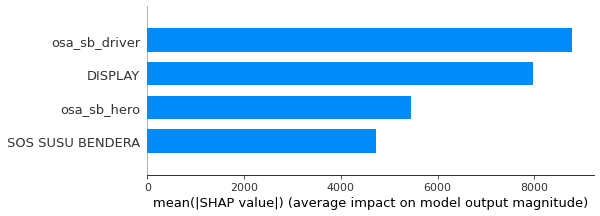

In [74]:
shap.summary_plot(shap_values, feature, max_display = 50, plot_type = 'bar')

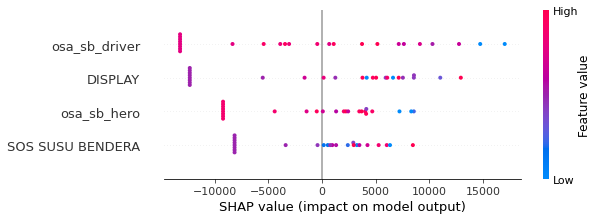

In [75]:
shap.summary_plot(shap_values, feature, max_display = 50)

In [27]:
shap_sum = shap_values.mean(axis=0)
importance_df = pd.DataFrame([feature.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'importance']

In [28]:
df_shap = pd.DataFrame(shap_values, columns=feat) 

In [29]:
importance_df

,column_name,importance
0,Consumer Promo - Gift redemption / Premium / B...,-193.099669
1,Consumer Promo - Multi buy,-621.986201
2,Consumer Promo - Price off,455.682894
3,DISPLAY,-356.57796
4,SOS IFT,-124.1146
5,SOS SUSU BENDERA,-270.751176
6,osa_sb_driver,-783.727409
7,osa_sb_hero,-448.495512
8,new_user,-86.393023


In [62]:
df[['Volume (KG)_Susu Bendera','Avg Price per Gr_Susu Bendera','pi_bebelac','pi_dancow','pi_ff','pi_lacto','pi_nestle','pi_sgm','pi_vidoran']].corr()

,Volume (KG)_Susu Bendera,Avg Price per Gr_Susu Bendera,pi_bebelac,pi_dancow,pi_ff,pi_lacto,pi_nestle,pi_sgm,pi_vidoran
Volume (KG)_Susu Bendera,1.000000,-0.207366,-0.244324,-0.173188,-0.138796,-0.404024,-0.428478,-0.341972,-0.349337
Avg Price per Gr_Susu Bendera,-0.207366,1.000000,0.947505,0.529417,-0.068492,0.696508,0.703603,0.811479,0.914980
pi_bebelac,-0.244324,0.947505,1.000000,0.643105,-0.266657,0.760237,0.677405,0.803864,0.952558
pi_dancow,-0.173188,0.529417,0.643105,1.000000,-0.191059,0.864224,0.481584,0.412264,0.729372
pi_ff,-0.138796,-0.068492,-0.266657,-0.191059,1.000000,-0.136332,0.077212,-0.236184,-0.118433
pi_lacto,-0.404024,0.696508,0.760237,0.864224,-0.136332,1.000000,0.605699,0.535842,0.846074
pi_nestle,-0.428478,0.703603,0.677405,0.481584,0.077212,0.605699,1.000000,0.526175,0.721017
pi_sgm,-0.341972,0.811479,0.803864,0.412264,-0.236184,0.535842,0.526175,1.000000,0.762804
pi_vidoran,-0.349337,0.914980,0.952558,0.729372,-0.118433,0.846074,0.721017,0.762804,1.000000


In [1196]:
importance_df.to_excel('FINAL RESULT/importance.xlsx', index=False)

In [115]:
mean_shap = df_shap.mean(axis=0)

In [118]:
explanation.mean(axis=0)

.values =
array([ -34.58975624,  -68.52837475,    4.26393678, -106.63101007,
       -160.62560877,  -28.11175036,   10.444253  ,  -26.07605331,
        -45.62456357, -274.13589517, -117.53827442,    8.66365021,
        -33.71953275,   -3.99146612,  -80.01372591,  166.02979869,
        -49.86710061,  -78.91557668,    9.71051347,  -62.33934645,
        -57.53050231, -172.51052885,   54.92758176, -117.52231643,
        -10.36965844,  -50.31774119,  -90.15746634, -195.82357344,
       -154.64833933,  -51.21323242,  -74.97583227, -127.98102068,
         48.51602031,   48.21352845,  -28.22312008,  -42.77963418,
        -41.14896926, -108.07697838,   -8.36838611,  -37.11767281,
         -5.7595174 , 1128.25377991,  -34.7311639 ,  100.39900012,
       -121.73296773,  -67.98468384,   -4.08027509])

.base_values =
190214.7387535829

.data =
array([1.70169163e+08, 1.63053121e+08, 9.18820789e+08, 2.50942067e+08,
       2.29979167e+08, 6.02658120e+07, 1.51991784e+08, 1.95565522e+07,
       5.900147

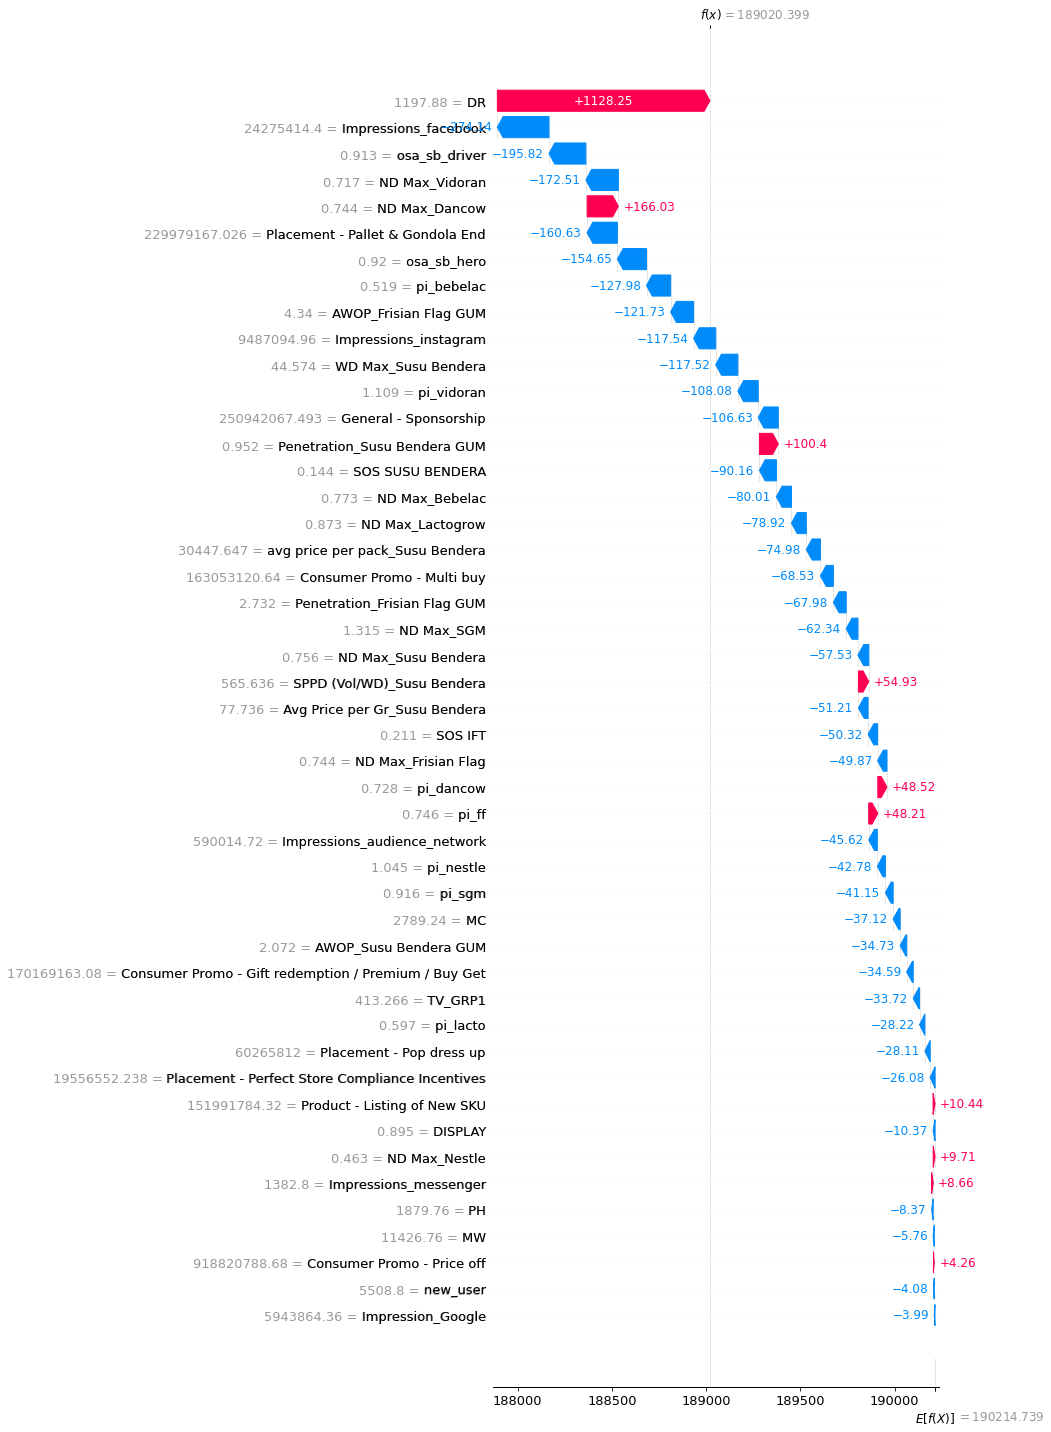

In [124]:
explanation = explainer(X=feature,y=target)
shap.plots.waterfall(explanation.mean(axis=0), show=False, max_display = 50)

In [50]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([df_used.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'importance']
importance_df = importance_df.reset_index(drop=True)

In [125]:
df[['Volume (KG)_Susu Bendera','DR','MW','PH','MC']].corr()

,Volume (KG)_Susu Bendera,DR,MW,PH,MC
Volume (KG)_Susu Bendera,1.000000,0.498135,0.509813,0.439426,0.378853
DR,0.498135,1.000000,0.297956,0.516748,0.003695
MW,0.509813,0.297956,1.000000,0.829486,0.947367
PH,0.439426,0.516748,0.829486,1.000000,0.710146
MC,0.378853,0.003695,0.947367,0.710146,1.000000


In [131]:
df20 = df.loc['2020-01-01':'2021-07-01']

In [132]:
df20[['osa_sb_driver','osa_sb_hero','DISPLAY','SOS IFT','SOS SUSU BENDERA','Volume (KG)_Susu Bendera']].corr()

,osa_sb_driver,osa_sb_hero,DISPLAY,SOS IFT,SOS SUSU BENDERA,Volume (KG)_Susu Bendera
osa_sb_driver,1.000000,0.729138,0.250184,-0.224454,-0.278180,-0.720549
osa_sb_hero,0.729138,1.000000,0.160689,-0.450849,-0.345642,-0.640212
DISPLAY,0.250184,0.160689,1.000000,0.376179,-0.079143,-0.170526
SOS IFT,-0.224454,-0.450849,0.376179,1.000000,0.496899,-0.066016
SOS SUSU BENDERA,-0.278180,-0.345642,-0.079143,0.496899,1.000000,-0.089584
Volume (KG)_Susu Bendera,-0.720549,-0.640212,-0.170526,-0.066016,-0.089584,1.000000


In [133]:
df20[['Volume (KG)_Susu Bendera','ND Max_Vidoran','ND Max_Susu Bendera','SPPD (Vol/ND)_Susu Bendera','DR','osa_sb_driver','AWOP_Susu Bendera GUM','Penetration_Susu Bendera GUM','new_user']].corr()

,Volume (KG)_Susu Bendera,ND Max_Vidoran,ND Max_Susu Bendera,SPPD (Vol/ND)_Susu Bendera,DR,osa_sb_driver,AWOP_Susu Bendera GUM,Penetration_Susu Bendera GUM,new_user
Volume (KG)_Susu Bendera,1.000000,0.285055,0.580714,0.443215,-0.223938,-0.720549,-0.444312,0.009984,-0.216949
ND Max_Vidoran,0.285055,1.000000,0.531193,-0.086954,-0.091897,-0.461278,-0.061637,0.014853,-0.028627
ND Max_Susu Bendera,0.580714,0.531193,1.000000,0.247833,-0.042320,-0.673249,-0.449585,-0.277084,-0.472315
SPPD (Vol/ND)_Susu Bendera,0.443215,-0.086954,0.247833,1.000000,-0.676154,-0.179809,-0.715226,-0.115092,-0.540135
DR,-0.223938,-0.091897,-0.042320,-0.676154,1.000000,0.260383,0.624888,-0.070840,0.172875
osa_sb_driver,-0.720549,-0.461278,-0.673249,-0.179809,0.260383,1.000000,0.442771,-0.032606,0.120490
AWOP_Susu Bendera GUM,-0.444312,-0.061637,-0.449585,-0.715226,0.624888,0.442771,1.000000,-0.200556,0.514678
Penetration_Susu Bendera GUM,0.009984,0.014853,-0.277084,-0.115092,-0.070840,-0.032606,-0.200556,1.000000,0.377897
new_user,-0.216949,-0.028627,-0.472315,-0.540135,0.172875,0.120490,0.514678,0.377897,1.000000


In [136]:
df[['Volume (KG)_Susu Bendera','Consumer Promo - Gift redemption / Premium / Buy Get',
         #'Consumer Promo - Loyalty Program',
         'Consumer Promo - Multi buy',
         'Consumer Promo - Price off',
         #'General - Distribution Service Fee',
         'General - Sponsorship',
         'Placement - Pallet & Gondola End',
         'Placement - Pop dress up',
         'Product - Listing of New SKU',
         #'Others - One-off  Distributor Salesman incentive',
         'Placement - Perfect Store Compliance Incentives']].corr()

,Volume (KG)_Susu Bendera,Consumer Promo - Gift redemption / Premium / Buy Get,Consumer Promo - Multi buy,Consumer Promo - Price off,General - Sponsorship,Placement - Pallet & Gondola End,Placement - Pop dress up,Product - Listing of New SKU,Placement - Perfect Store Compliance Incentives
Volume (KG)_Susu Bendera,1.000000,0.217446,0.251697,0.706314,0.247946,0.239863,-0.547980,0.138708,0.095940
Consumer Promo - Gift redemption / Premium / Buy Get,0.217446,1.000000,-0.281418,0.089843,-0.262674,0.047007,-0.098673,0.413520,-0.041747
Consumer Promo - Multi buy,0.251697,-0.281418,1.000000,-0.006584,0.254861,0.062736,0.262071,-0.142464,-0.167326
Consumer Promo - Price off,0.706314,0.089843,-0.006584,1.000000,0.000638,0.380652,-0.510820,0.112929,-0.014596
General - Sponsorship,0.247946,-0.262674,0.254861,0.000638,1.000000,0.073856,-0.180167,-0.016076,-0.092639
Placement - Pallet & Gondola End,0.239863,0.047007,0.062736,0.380652,0.073856,1.000000,-0.377995,-0.124232,-0.196098
Placement - Pop dress up,-0.547980,-0.098673,0.262071,-0.510820,-0.180167,-0.377995,1.000000,0.059458,-0.173859
Product - Listing of New SKU,0.138708,0.413520,-0.142464,0.112929,-0.016076,-0.124232,0.059458,1.000000,0.157201
Placement - Perfect Store Compliance Incentives,0.095940,-0.041747,-0.167326,-0.014596,-0.092639,-0.196098,-0.173859,0.157201,1.000000
